# Modified Black Jack: A Cards Game

## Objective

In this assignment we are understanding Monte Carlo Control and TD Learning - DRL using a modified Black Jack card game.
- This assignment includes the algorithm implementations and visualization and comparison of the plots.

### Import libraries

In [3]:
#Import libraries 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict 
import seaborn as sns

### Game Environment Rules

- Infinite deck, cards mapped 1 - 13. Where Jack = 11, Queen = 12, King = 13.
- Draw red card probability (1/3) and for black it is (2/3).
- Player and dealer start with one black card.
- Player can *Hit* or *Stick*.
- Dealer hits until sum >= 17.
- Bust, if sum <1 or >21 -> reward = -1, if player sum > dealer -> reward = 1, if terminal -> reward = 0.
- We have created draw_card(), step(), init_game() function overall to setup the game environment.

### Game Environment Implementation

#### Draw card function

In [4]:
#draw card fucntion 
#draw black 2/3 or red 1/3 from value 1-13
def draw_card():
    value = np.random.randint(1, 14)    #1 to 13 cards
    color = 'black' if np.random.random() > 1/3 else 'red'  #between 0.0 - 1.0 
    return value, color

#Map the face cards with number for better result display  #just for the info
def card_name(value):
    if value == 11:
        return "Jack"
    elif value == 12:
        return "Queen"
    elif value == 13:
        return "King"
    else:
        return str(value)

#### Step function() for the game moves

In [5]:
def step(state, action):
    dealers_card, player_sum, terminal = state

    if terminal:
        return state, 0

    if action == 'hit':  #Player draws a card
        value, color = draw_card()
        if color == 'black':
            player_sum += value 
        else: #red
            player_sum -= value

        #Check bust for player 
        if player_sum > 21 or player_sum < 1:
            return (dealers_card, player_sum, True), -1

        return (dealers_card, player_sum, False), 0

    if action == 'stick':
        #Dealer's turn 
        dealer_sum = dealers_card  #Initial start 

        #dealer hits until > 17 sum
        while dealer_sum < 17:
            value, color = draw_card()
            if color == 'black':
                dealer_sum += value
            else: 
                dealer_sum -= value

            #Check bust for dealer
            if dealer_sum > 21 or dealer_sum < 1:
                return (dealers_card, player_sum, True), 1   #Win for player

        if player_sum > dealer_sum:
            reward = 1
        elif player_sum < dealer_sum:
            reward = -1
        else:
            reward = 0

        return (dealers_card, player_sum, True), reward
                
        

#### Initialize game

In [6]:
#fucntion to initialize 
def init_game():
    #setup both dealer and players first card black
    dealer_card = np.random.randint(1, 14)  #We are not using draw_card function for initial start so the cards are bydeafult black
    player_sum = np.random.randint(1, 14)
    return (dealer_card, player_sum, False)

## Monte Carlo

As per the instructions, we used **Monte Carlo Control with ε-greedy exploration**

**Parameters:**
- Step size: αₜ = 1 / N(s, a)
- Exploration rate: εₜ = N₀ / (N₀ + N(s)), with N₀ = 100
- No discount factor: γ = 1 (treating the dealer’s moves as part of the environment)
- The code handles action value function Q(s,a) using episode returns.

### ε-greedy exploration function for Monte Carlo

In [7]:
def e_greedy(Q, state, N_state, N0=100):
    epsilon = N0 / (N0 + N_state[state])

    if np.random.random() < epsilon:
        return np.random.choice(['hit', 'stick'])
    else:
        #choice action with highest q value 
        q_hit = Q.get((state, 'hit'), 0)
        q_stick = Q.get((state, 'stick'), 0)
        return 'hit' if q_hit > q_stick else 'stick'

## Monte Carlo Control function

In [8]:
def monte_carlo_control(n_episodes=500000, N0=100):
    #forward view episode based update
    Q = defaultdict(float) #action-value function
    N_sa = defaultdict(float) #count of state, action 
    N_s = defaultdict(float) #count of state 

    for episode in range(n_episodes):
        state = init_game()
        episode_data = []

        while not state[2]:    #till it terminal
            action = e_greedy(Q, state, N_s, N0)
            next_state, reward = step(state, action)
            episode_data.append((state, action, reward))
            state = next_state

        #Update q value using the episode 
        G = 0
        visited_sa = set()

        #work backwards through the episode
        for state, action, reward in reversed(episode_data):
            G = reward + G

            if (state, action) not in visited_sa:
                visited_sa.add((state, action))
                N_sa[(state, action)] += 1
                N_s[state] += 1

                alpha = 1.0 / N_sa[(state, action)]
                Q[(state, action)] += alpha * (G - Q[(state, action)])

        if (episode + 1) % 50000 == 0:
            print(f"Episode {episode + 1}/{n_episodes}")

    return Q, N_sa, N_s

### Monte Carlo Control function initiation step

In [9]:
#Initiate the monte carlo
Q_star, N_Sa, N_s = monte_carlo_control(n_episodes=500000, N0=100)
print(f"\n Monte Carlo training completed")
print(f"\n Total state-action pairs learned: {len(Q_star)}")

Episode 50000/500000
Episode 100000/500000
Episode 150000/500000
Episode 200000/500000
Episode 250000/500000
Episode 300000/500000
Episode 350000/500000
Episode 400000/500000
Episode 450000/500000
Episode 500000/500000

 Monte Carlo training completed

 Total state-action pairs learned: 546


## Plot Optimal value function

We are visualizing V*(s) = maxₐ Q*(s, a)

Axes:
- X-axis -> Dealer's first card 1-13
- Y-axis -> Player's sum 1-21
- Z-axis -> Optimal Vlaue V*(s)

In [17]:
def plot_value_fn(Q):
    #create grid for dealer cards 1-13 and player sum 1-21
    dealer_cards = np.arange(1, 14)
    player_sums = np.arange(1, 22)

    X, Y = np.meshgrid(dealer_cards, player_sums)
    Z = np.zeros_like(X, dtype=float)

    #Compute the Optimal function V*(s) = max_a Q*(s,a)
    for i, player_sum in enumerate(player_sums):
        for j, dealer_card in enumerate(dealer_cards):
            state = (dealer_card, player_sum, False)
            q_hit = Q.get((state, 'hit'), 0)
            q_stick = Q.get((state, 'stick'), 0)
            Z[i,j] = max(q_hit, q_stick)

    #3d plot 
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='none', linewidth=0, antialiased=True)
    
    ax.set_xlabel('Dealers Showing')
    ax.set_ylabel('Player Sum')
    ax.set_zlabel('Value')
    ax.set_title("Optimal Value Fucntion V*(s)")
    ax.set_xlim(1, 13)
    ax.set_ylim(1, 21)
    plt.show()

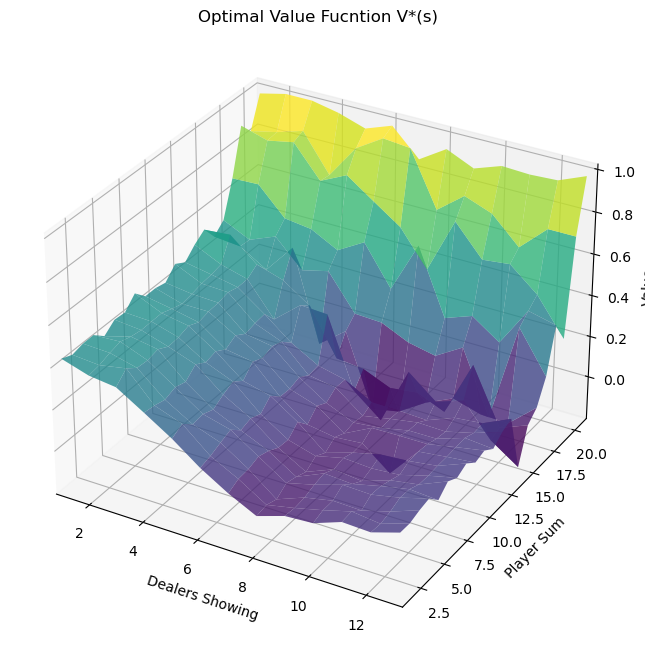

In [18]:
#Plot the Monte Carlo - Optimal function plot

#plot 
plot_value_fn(Q_star)

-------------------------------------------------------------------------------------------------------------------------------

## TD Learning (Temporal Difference Learning)- SARSA(λ)

- Now, we have implemented the **forward view** version of SARSA(λ).
- The algorithm calculates Q(s,a) for each lambda λ ∈ {0, 0.1, 0.2, …, 1}.

### Compute MSE function

In [75]:
def calculate_mse(Q, Q_star):
    mse = 0
    count = 0

    #loop though all the state and actions possible and calcualte the values
    for dealer_card in range(1, 14):
        for player_sum in range(1, 22):
            state = (dealer_card, player_sum, False)
            for action in ['hit', 'stick']:
                q_star = Q_star.get((state, action), 0)
                q = Q.get((state, action), 0)
                mse += (q - q_star) ** 2
                count += 1

    return mse / count if count > 0 else 0

### SARSA(λ) Forward view function

In [77]:
#function initialized 
def sarsa_lambda(Q_star, n_episodes=1000, lambda_val=0.5, N0=100):
    Q = defaultdict(float)
    N_sa = defaultdict(int)
    N_s = defaultdict(int)

    mse_by_ep = []

    for episode in range(n_episodes):
        #generate a episode 
        state = init_game()
        action = e_greedy(Q, state, N_s, N0)
        episode_data = []

        while not state[2]:
            #when not terminal 
            next_state, reward = step(state, action)

            episode_data.append((state, action, reward))

            state = next_state
            if not state[2]:
                action = e_greedy(Q, state, N_s, N0)

        #forward view - calculate λ return for each step
        T = len(episode_data)    #Total number of time steps

        for t in range(T):
            state_t, action_t, reward_t = episode_data[t]

            #To compute λ return G_t^λ
            lambda_return = 0.0

            # λ = 0 - only 1 step return
            if lambda_val == 0.0:
                G_1 = reward_t
                if t + 1 < T:
                    next_state_1, next_action_1, _ = episode_data[t + 1]
                    G_1 += Q.get((next_state_1, next_action_1), 0)
                lambda_return = G_1

            # λ = 1
            elif lambda_val == 1.0:
                G_mc = 0
                for k in range(t, T):
                    _, _, r_k = episode_data[k]
                    G_mc += r_k
                lambda_return = G_mc

            else:
                max_n = T - t
                #compute n step returns 
                for n in range(1, max_n + 1):
                    G_n = 0.0
                    for k in range(t, t + n):
                        _, _, r_k = episode_data[k]
                        G_n += r_k                   #add reward  and no discount 
    
                    if t + n < T:
                        new_next_state, new_next_action, _ = episode_data[t + n]
                        G_n += Q.get((new_next_state, new_next_action), 0)
    
                    if n < max_n:  #weight for each n step
                        weight = (1.0 - lambda_val) * (lambda_val ** (n - 1))
                    else:
                        weight = lambda_val ** (max_n - 1)
    
                    lambda_return += weight * G_n

            #udpate q values 
            N_sa[(state_t, action_t)] += 1
            N_s[state_t] += 1
            alpha = 1.0 / N_sa[(state_t, action_t)]
            Q[(state_t, action_t)] += alpha * (lambda_return - Q[(state_t, action_t)])

        #compute MSE
        if episode % 10 == 0:
            mse = calculate_mse(Q, Q_star)
            mse_by_ep.append(mse)

        if (episode + 1) % 100 == 0:
            sample_state = (10, 15, False)
            q_hit = Q.get((sample_state, 'hit'), 0)
            q_stick = Q.get((sample_state, 'stick'), 0)
            print(f"Sarsa(λ={lambda_val}) Episode {episode + 1}/{n_episodes} | Q(s,hit)={q_hit:.4f}, Q(s,stick)={q_stick:.4f}")

    return Q, mse_by_ep
            

### Sarsa(λ) initiation step for different lambda values 

In [78]:
lambda_vals = [ 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
mse_vals = []

mse_lambda_0 = None
mse_lambda_1 = None

#Loop through all the lambda values
for lambda_val in lambda_vals:
    print("\nRunning Sarsa lambda value:", lambda_val)
    Q_lambda, mse_by_ep = sarsa_lambda(Q_star, n_episodes=1000, lambda_val=lambda_val, N0=100)

    n_mse = mse_by_ep[-1] if mse_by_ep else 0
    mse_vals.append(n_mse)
    print(f"Final MSE for λ={lambda_val}:{n_mse:.6f}")

    #store the learning curves for the plot 
    if lambda_val == 0.0:
        mse_lambda_0 = mse_by_ep
    elif lambda_val == 1.0:
        mse_lambda_1 = mse_by_ep


Running Sarsa lambda value: 0.0
Sarsa(λ=0.0) Episode 100/1000 | Q(s,hit)=0.0000, Q(s,stick)=0.0000
Sarsa(λ=0.0) Episode 200/1000 | Q(s,hit)=-1.0000, Q(s,stick)=0.0000
Sarsa(λ=0.0) Episode 300/1000 | Q(s,hit)=-1.0000, Q(s,stick)=0.0000
Sarsa(λ=0.0) Episode 400/1000 | Q(s,hit)=-1.0000, Q(s,stick)=0.0000
Sarsa(λ=0.0) Episode 500/1000 | Q(s,hit)=-1.0000, Q(s,stick)=0.0000
Sarsa(λ=0.0) Episode 600/1000 | Q(s,hit)=-1.0000, Q(s,stick)=1.0000
Sarsa(λ=0.0) Episode 700/1000 | Q(s,hit)=-1.0000, Q(s,stick)=1.0000
Sarsa(λ=0.0) Episode 800/1000 | Q(s,hit)=-1.0000, Q(s,stick)=1.0000
Sarsa(λ=0.0) Episode 900/1000 | Q(s,hit)=-1.0000, Q(s,stick)=1.0000
Sarsa(λ=0.0) Episode 1000/1000 | Q(s,hit)=-1.0000, Q(s,stick)=1.0000
Final MSE for λ=0.0:0.267514

Running Sarsa lambda value: 0.1
Sarsa(λ=0.1) Episode 100/1000 | Q(s,hit)=0.0000, Q(s,stick)=1.0000
Sarsa(λ=0.1) Episode 200/1000 | Q(s,hit)=0.0000, Q(s,stick)=1.0000
Sarsa(λ=0.1) Episode 300/1000 | Q(s,hit)=0.0000, Q(s,stick)=1.0000
Sarsa(λ=0.1) Episode 400

## Compute and plot 

- Mean Squared Error(MSE) vs λ.
- Learning curves (MSE vs Episode) for λ = 0 and λ = 1.

### Plot MSE vs Lmabda

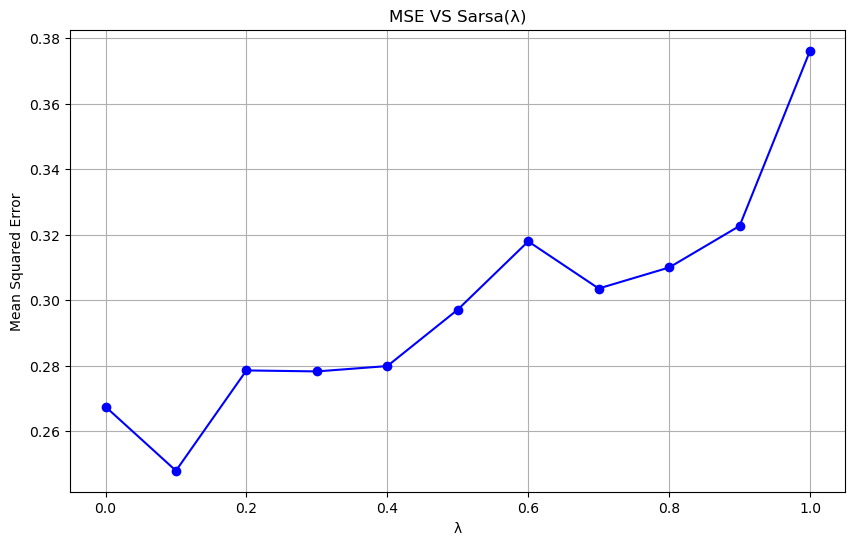

In [84]:
def plot_mse_lambda(lambda_values, mse_values):
    plt.figure(figsize=(10, 6))
    plt.plot(lambda_values, mse_values, 'bo-')
    plt.xlabel('λ')
    plt.ylabel('Mean Squared Error')
    plt.title('MSE VS Sarsa(λ)')
    plt.grid(True)
    plt.show()


#plot call
plot_mse_lambda(lambda_vals, mse_vals)

### Plot learning curves for 0 and 1 λ

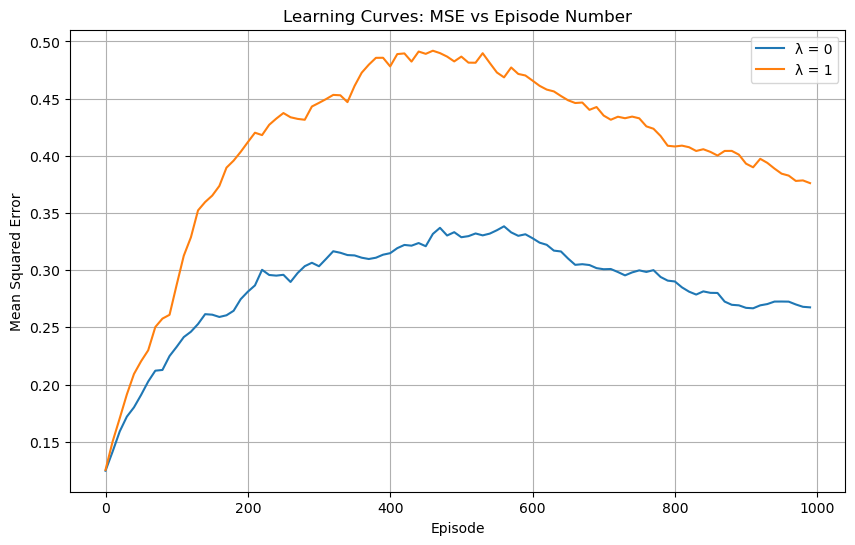

In [85]:
def plot_learning_curves(mse_0, mse_1):
    plt.figure(figsize=(10,6))
    ep0 = np.arange(0, len(mse_0)) * 10
    ep1 = np.arange(0, len(mse_1)) * 10

    plt.plot(ep0, mse_0, label='λ = 0')
    plt.plot(ep1, mse_1, label='λ = 1')

    plt.xlabel('Episode')
    plt.ylabel('Mean Squared Error')
    plt.title('Learning Curves: MSE vs Episode Number')
    plt.legend()
    plt.grid(True)
    plt.show()

#call plot
if mse_lambda_0 and mse_lambda_1:
    plot_learning_curves(mse_lambda_0, mse_lambda_1)

## Results & Discussion

- **Monte Carlo Control:** The value function converges smoothly and shows clear preference for high sum values.
- **Sarsa(λ):** On each λ increase from 0.1 to 1.0, which helps MSE curve to identify the best λ.
- **Comparison:** λ = 0 converges faster then λ = 1 as we can see it in the graph above.

## Conclusion

In this assignment, we learned to implement the 2 algorithms Monte Carlo Control and TD Learning (λ) Sarsa.